In [17]:
import numpy as np
#%tensorflow_version 2.x
import tensorflow as tf
import matplotlib.pyplot as plt
import tensorflow_datasets as tfds

from tensorflow.keras import Model
from tensorflow.keras.layers import Layer

In [18]:
# Load dataset, split into test and training data
train_ds, test_ds = tfds.load('cifar10', split= ['train', 'test'], data_dir="data\\", as_supervised=True)

In [19]:
def overview_data():
  train_ds_numpy = tfds.as_numpy(train_ds)
  test_ds_numpy = tfds.as_numpy(test_ds)

  #Look at shapes images and labels of dataset
  print("length train: ",len(train_ds))
  print("length train: ",len(test_ds))

  x = 0
  for i in train_ds_numpy:
    x += 1
    print("shape ",format(i[0].shape))
    print("max ",np.amax(i[0]))
    print("min ",np.amin(i[0]))
    print(format(i[1]))
    if x == 3:
      break

  x = 0
  for i in test_ds_numpy:
    x += 1
    print("shape ",format(i[0].shape))
    print("max ",np.amax(i[0]))
    print("min ",np.amin(i[0]))
    print(format(i[1]))
    if x == 3:
      break

In [20]:
def plot_data():
  train_ds_numpy = tfds.as_numpy(train_ds)
  test_ds_numpy = tfds.as_numpy(test_ds)

  # Plot 5 samples with their corresponding label.
  fig, ax = plt.subplots(1,5)
  x = 0
  for j in train_ds_numpy:
    
    # Readout an image and the corresponding label.
    img = j[0]

    label = {
        0 : 'airplane',
        1 : 'automobile',
        2 : 'bird',
        3 : 'cat',
        4 : 'deer',
        5 : 'dog',
        6 : 'frog',
        7 : 'horse',
        8 : 'ship',
        9 : 'truck'
    }
    # if label is still just an integer
    if isinstance(j[1], np.int64):
      lbl = label[j[1]]
    # if label is already an one-hot vektor
    else:
      indice = np.where(j[1] == 1)
      indice = indice[0]
      lbl = label[int(indice)]

    ax[x].imshow(img)
    ax[x].set_title(lbl)
    ax[x].axis("off")

    x += 1

    if x==5:
      break

length train:  50000
length train:  10000
shape  (32, 32, 3)
max  1.6242564
min  -2.2864254
[0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
shape  (32, 32, 3)
max  2.317584
min  -1.7136855
[0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
shape  (32, 32, 3)
max  3.1003594
min  -3.4322746
[0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
shape  (32, 32, 3)
max  1.3148377
min  -1.5812476
[0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
shape  (32, 32, 3)
max  3.6264737
min  -1.5439444
[1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
shape  (32, 32, 3)
max  2.993287
min  -2.1075056
[0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
W1209 20:07:34.456057 16928 image.py:648] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
W1209 20:07:34.459057 16928 image.py:648] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
W1209 20:07:34.461058 16928 image.py:648] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
W1209 20:07:

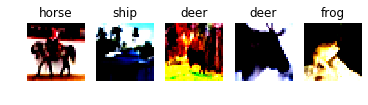

In [21]:
#Build input pipeline
train_ds = train_ds.map(lambda image, label: (tf.image.per_image_standardization(tf.cast(image, tf.float32)), tf.reshape(tf.one_hot(label, 10), (-1,))))
test_ds = test_ds.map(lambda image, label: (tf.image.per_image_standardization(tf.cast(image, tf.float32)), tf.reshape(tf.one_hot(label, 10), (-1,))))

overview_data()
plot_data()

prefetch_size = tf.data.experimental.AUTOTUNE
print("Autotune: ",prefetch_size)

# batching, shuffle und prefetching
train_ds = train_ds.batch(64).shuffle(buffer_size=64).prefetch(prefetch_size)
test_ds = test_ds.batch(64).shuffle(buffer_size=64).prefetch(prefetch_size)

# Resnet

In [22]:
class ResidualBlock(Layer):

    def __init__(self,channels,maps):
        super(ResidualBlock, self).__init__()
        self.channels = channels
        self.maps = maps
        self.conv_1 = tf.keras.layers.Conv2D(filters = maps,
                                         kernel_size = 1,
                                         activation = None,
                                         padding = 'same',
                                         kernel_initializer = tf.keras.initializers.glorot_normal,   # (1)
                                         bias_initializer = 'zeros',                                 # (2)
                                         kernel_regularizer = tf.keras.regularizers.L2(0.01),        # (3)
                                         input_shape = (64, 32, 32, channels))
        self.batch_norm_1 = tf.keras.layers.BatchNormalization()                                         # (4)
        self.activ_1 = tf.keras.activations.relu

        self.conv_2 = tf.keras.layers.Conv2D(filters = maps,
                                         kernel_size = 3,
                                         activation = None,
                                         padding = 'same',
                                         kernel_initializer = tf.keras.initializers.glorot_normal,   # (1)
                                         bias_initializer = 'zeros',                                 # (2)
                                         kernel_regularizer = tf.keras.regularizers.L2(0.01))        # (3)

        self.batch_norm_2 = tf.keras.layers.BatchNormalization()                                         # (4)
        self.activ_2 = tf.keras.activations.relu

        self.conv_3 = tf.keras.layers.Conv2D(filters = channels,
                                         kernel_size = 1,
                                         activation = None,
                                         padding = 'same',
                                         kernel_initializer = tf.keras.initializers.glorot_normal,   # (1)
                                         bias_initializer = 'zeros',                                 # (2)
                                         kernel_regularizer = tf.keras.regularizers.L2(0.01))        # (3)
        self.batch_norm_3 = tf.keras.layers.BatchNormalization()                                         # (4)
        self.activ_3 = tf.keras.activations.relu

    def call(self,x,training):
        inp = x
        # print(f"ResBlock: channels {self.channels}, maps {self.maps}")

        x = self.conv_1(x)
        x = self.batch_norm_1(x,training=training)
        x = self.activ_1(x)
        
        x = self.conv_2(x)
        x = self.batch_norm_2(x,training=training)
        x = self.activ_2(x)

        x = self.conv_3(x)
        x = self.batch_norm_3(x,training=training)
        x = self.activ_3(x)

        x = tf.add(inp,x)
        x = tf.keras.activations.relu(x)

        return x


In [23]:
class ResNet(Model):
    def __init__(self,blocks,channels,maps):
        super(ResNet, self).__init__()
        self.conv_1 = tf.keras.layers.Conv2D(filters = channels,
                                         kernel_size = 3,
                                         activation = None,
                                         padding = 'same',
                                         kernel_initializer = tf.keras.initializers.glorot_normal,   # (1)
                                         bias_initializer = 'zeros',                                 # (2)
                                         kernel_regularizer = tf.keras.regularizers.L2(0.01),        # (3)
                                         input_shape = (64, 32, 32, 3))
        self.batch_norm_1 = tf.keras.layers.BatchNormalization()                                         # (4)
        self.activ_1 = tf.keras.activations.relu

        self.blocks=[]
        for i in range(0,blocks):
            self.blocks.append(ResidualBlock(channels,maps))
            print(channels," ",maps)
            channels = channels/2
            self.blocks.append(tf.keras.layers.Conv2D(filters = channels, kernel_size = 1))
            maps = maps*2
            if i != blocks-1:
                self.blocks.append(tf.keras.layers.MaxPool2D(pool_size=(2, 2), strides=None, padding='valid'))
            

        self.global_pooling_layer_8 = tf.keras.layers.GlobalAveragePooling2D()

        self.output_layer_10 = tf.keras.layers.Dense(units=10, activation=tf.keras.activations.softmax)




    def call(self,x,training):
        x = self.conv_1(x)
        x = self.batch_norm_1(x,training=training)
        x = self.activ_1(x)

        for i in self.blocks:
            x = i(x,training=training)
            

        x = self.global_pooling_layer_8(x)
        x = self.output_layer_10(x)
        
        return x



# DenseNet

In [24]:
class TransitionLayer(Layer):

    def __init__(self,):
        super(TransitionLayer, self).__init__()

        self.conv_1 = tf.keras.layers.Conv2D(filters = 64,
                                         kernel_size = 1,
                                         activation = None,
                                         padding = 'same',
                                         kernel_initializer = tf.keras.initializers.glorot_normal,   # (1)
                                         bias_initializer = 'zeros',                                 # (2)
                                         kernel_regularizer = tf.keras.regularizers.L2(0.01))        # (3)
        self.batch_norm_1 = tf.keras.layers.BatchNormalization()                                         # (4)
        self.activ_1 = tf.keras.activations.relu
        
        self.pool1 = tf.keras.layers.AveragePooling2D(pool_size=(1,1),strides=(1,1))


    def call(self,x):

        return x


In [25]:
class DenseBlock(Layer):

    def __init__(self):
        super(DenseBlock, self).__init__()

        self.conv_1 = tf.keras.layers.Conv2D(filters = 64,
                                         kernel_size = 3,
                                         activation = None,
                                         padding = 'same',
                                         kernel_initializer = tf.keras.initializers.glorot_normal,   # (1)
                                         bias_initializer = 'zeros',                                 # (2)
                                         kernel_regularizer = tf.keras.regularizers.L2(0.01))        # (3)
                                         #input_shape = (32, 32, 3))
        self.batch_norm_1 = tf.keras.layers.BatchNormalization()                                         # (4)
        self.activ_1 = tf.keras.activations.relu

        self.conv_2 = tf.keras.layers.Conv2D(filters = 64,
                                         kernel_size = 3,
                                         activation = None,
                                         padding = 'same',
                                         kernel_initializer = tf.keras.initializers.glorot_normal,   # (1)
                                         bias_initializer = 'zeros',                                 # (2)
                                         kernel_regularizer = tf.keras.regularizers.L2(0.01))        # (3))
        self.batch_norm_2 = tf.keras.layers.BatchNormalization()                                         # (4)
        self.activ_2 = tf.keras.activations.relu

        self.conv_3 = tf.keras.layers.Conv2D(filters = 64,
                                         kernel_size = 3,
                                         activation = None,
                                         padding = 'same',
                                         kernel_initializer = tf.keras.initializers.glorot_normal,   # (1)
                                         bias_initializer = 'zeros',                                 # (2)
                                         kernel_regularizer = tf.keras.regularizers.L2(0.01))        # (3))
        self.batch_norm_3 = tf.keras.layers.BatchNormalization()                                         # (4)
        self.activ_3 = tf.keras.activations.relu     


    def call(self,x,training):
        inp = x
        # print(f"ResBlock: channels {self.channels}, maps {self.maps}")

        x = self.conv_1(x)
        x = self.batch_norm_1(x,training=training)
        x = self.activ_1(x)
        
        x = self.conv_2(x)
        x = self.batch_norm_2(x,training=training)
        x = self.activ_2(x)

        x = self.conv_3(x)
        x = self.batch_norm_3(x,training=training)
        x = self.activ_3(x)


        tf.concat(inp, outp)

        return x

In [26]:
class DenseNet(Model):

    def __init__(self,blocks,growth_rate):
        super(DenseNet, self).__init__()

        self.conv_1 = tf.keras.layers.Conv2D(filters = channels,
                                         kernel_size = 3,
                                         activation = None,
                                         padding = 'same',
                                         kernel_initializer = tf.keras.initializers.glorot_normal,   # (1)
                                         bias_initializer = 'zeros',                                 # (2)
                                         kernel_regularizer = tf.keras.regularizers.L2(0.01),        # (3)
                                         input_shape = (64, 32, 32, 3))
        self.batch_norm_1 = tf.keras.layers.BatchNormalization()                                         # (4)
        self.activ_1 = tf.keras.activations.relu

        self.blocks=[]
        for i in range(0,blocks):
            self.blocks.append(DenseBlock())
            self.blocks.append(TransitionLayer(growth_rate))


        self.global_pooling_layer_8 = tf.keras.layers.GlobalAveragePooling2D()

        self.output_layer_10 = tf.keras.layers.Dense(units=10, activation=tf.keras.activations.softmax)


    def call(self,x,training):
        
        x = self.conv_1(x)
        x = self.batch_norm_1(x,training=training)
        x = self.activ_1(x)

        for i in self.blocks:
            x = i(x,training=training)
            

        x = self.global_pooling_layer_8(x)
        x = self.output_layer_10(x)

        return x

In [27]:
def train_step(model, data, target, loss_function, optimizer):
  # loss_object and optimizer_object are instances of respective tensorflow classes
  
  with tf.GradientTape() as tape:
    prediction = model(data, training = True)
    loss = loss_function(target, prediction)
    gradients = tape.gradient(loss, model.trainable_variables)
  
  optimizer.apply_gradients(zip(gradients, model.trainable_variables))
  
  return loss 

def test_step(model, test_data, loss_function):
  # test over complete test data

  test_accuracy_aggregator = []
  test_loss_aggregator = []

  for (data, target) in test_data:
    prediction = model(data, training = False)
    
    sample_test_loss = loss_function(target, prediction)
    sample_test_accuracy =  np.argmax(target, axis=1) == np.argmax(prediction, axis=1)
    sample_test_accuracy = np.mean(sample_test_accuracy)

    test_loss_aggregator.append(sample_test_loss.numpy())
    test_accuracy_aggregator.append(np.mean(sample_test_accuracy))

  test_loss = np.mean(test_loss_aggregator)
  test_accuracy = np.mean(test_accuracy_aggregator)

  return test_loss, test_accuracy

32   32
16.0   64
8.0   128
Epoch: __ 0


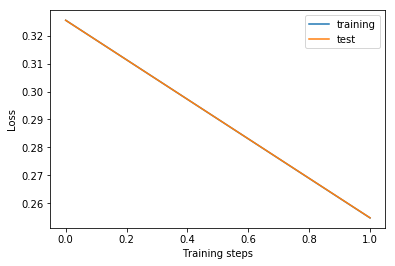

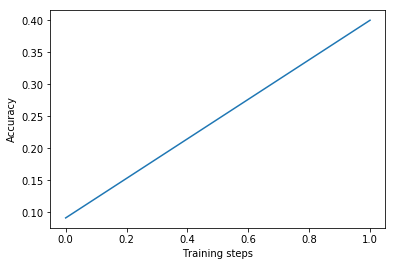

Epoch: __ 1


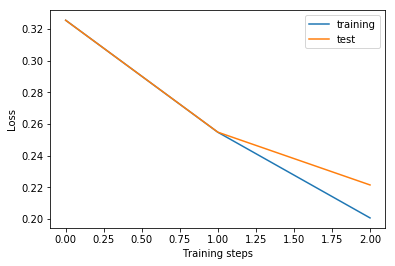

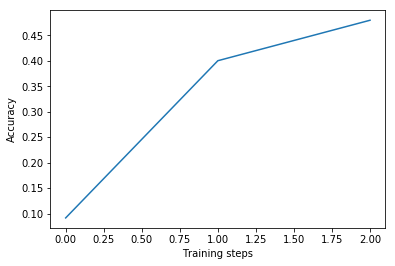

Epoch: __ 2


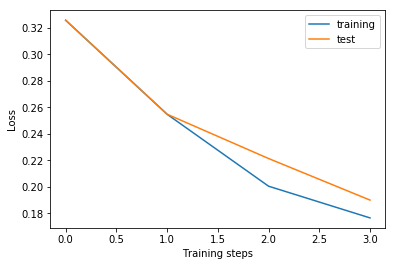

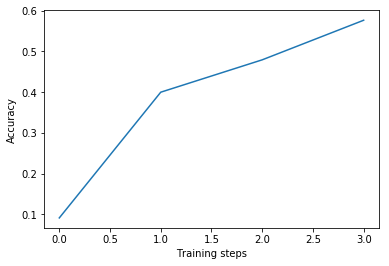

Epoch: __ 3


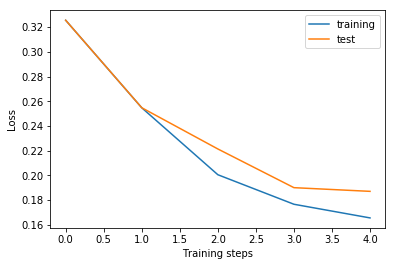

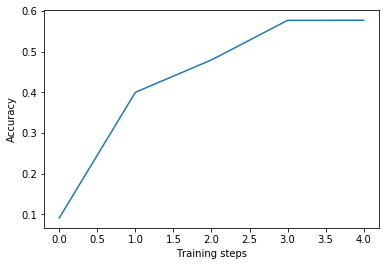

Epoch: __ 4


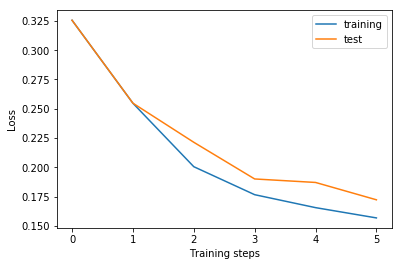

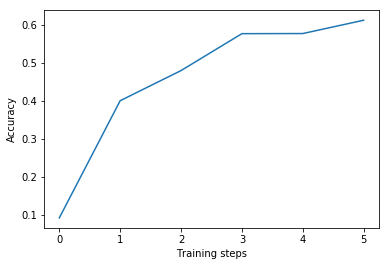

Epoch: __ 5


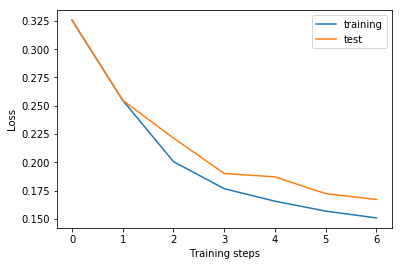

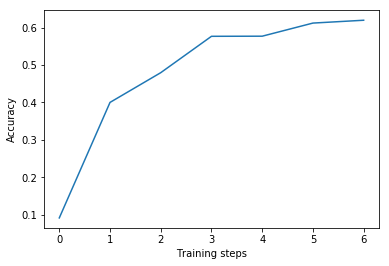

Epoch: __ 6


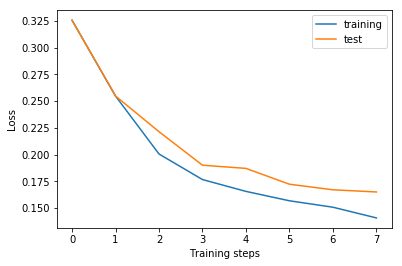

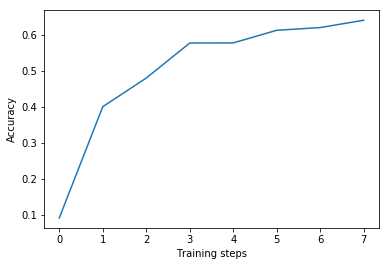

Epoch: __ 7


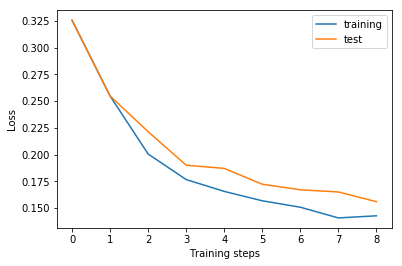

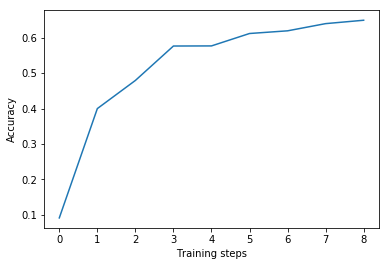

Epoch: __ 8


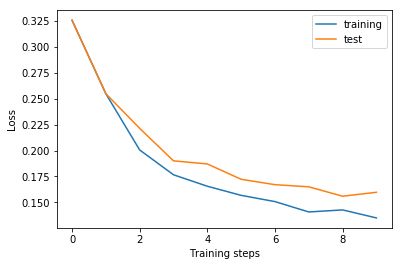

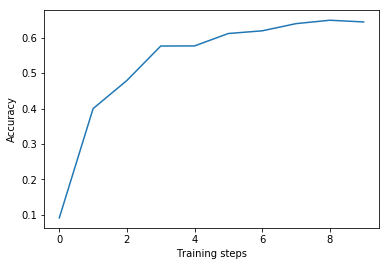

Epoch: __ 9


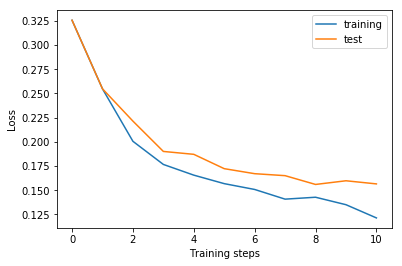

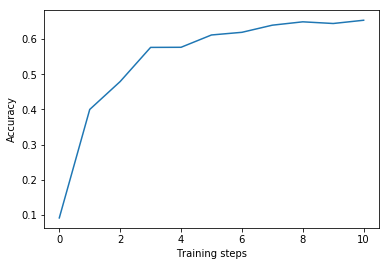

In [15]:
tf.keras.backend.clear_session()

### Hyperparameters
num_epochs = 20
learning_rate = 0.0005
running_average_factor = 0.95

# Initialize the model.
model = ResNet(3,32,32)
# model = DenseNet()


# Initialize the loss: categorical cross entropy. Check out 'tf.keras.losses'.
cross_entropy_loss = tf.keras.losses.BinaryCrossentropy()
# Initialize the optimizer: Adam with default parameters. Check out 'tf.keras.optimizers'
optimizer = tf.keras.optimizers.Adam(learning_rate)

# Initialize lists for later visualization.
train_losses = []
test_losses = []
test_accuracies = []

#testing once before we begin
test_loss, test_accuracy = test_step(model, test_ds, cross_entropy_loss)
test_losses.append(test_loss)
test_accuracies.append(test_accuracy)

#check how model performs on train data once before we begin
train_loss, _ = test_step(model, train_ds, cross_entropy_loss)
train_losses.append(train_loss)

# We train for num_epochs epochs.
for epoch in range(num_epochs):
    print('Epoch: __ ' + str(epoch))

    #training (and checking in with training)
    running_average = 0
    for (data,target) in train_ds:
        train_loss = train_step(model, data, target, cross_entropy_loss, optimizer)
        running_average = running_average_factor * running_average  + (1 - running_average_factor) * train_loss
    train_losses.append(running_average)

    #testing
    test_loss, test_accuracy = test_step(model, test_ds, cross_entropy_loss)
    test_losses.append(test_loss)
    test_accuracies.append(test_accuracy)

    # Visualize accuracy and loss for training and test data. 
    # One plot training and test loss.
    # One plot training and test accuracy.
    plt.figure()
    line1, = plt.plot(train_losses)
    line2, = plt.plot(test_losses)
    plt.xlabel("Training steps")
    plt.ylabel("Loss")
    plt.legend((line1,line2),("training","test"))
    plt.show()

    plt.figure()
    line1, = plt.plot(test_accuracies)
    plt.xlabel("Training steps")
    plt.ylabel("Accuracy")
    plt.show()

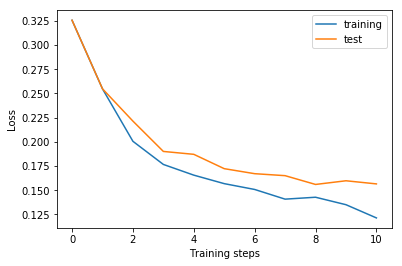

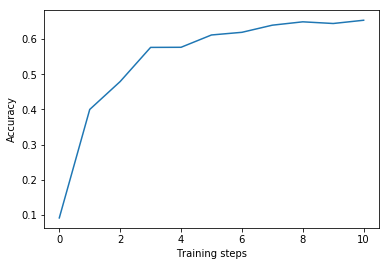

In [16]:
# Visualize accuracy and loss for training and test data. 
# One plot training and test loss.
# One plot training and test accuracy.
plt.figure()
line1, = plt.plot(train_losses)
line2, = plt.plot(test_losses)
plt.xlabel("Training steps")
plt.ylabel("Loss")
plt.legend((line1,line2),("training","test"))
plt.show()

plt.figure()
line1, = plt.plot(test_accuracies)
plt.xlabel("Training steps")
plt.ylabel("Accuracy")
plt.show()